In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pandas as pd

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

from matplotlib.colorbar import ColorbarBase

In [3]:
import cmocean

In [4]:
import graphufs
from graphufs.spatialmap import SpatialMap
plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [5]:
ds = xr.open_zarr("/p1-evaluation/v1/long-forecasts/graphufs.2019-01-01T00.8754h.zarr/")
sds = xr.open_zarr("/p1-evaluation/v1/long-forecasts/graphufs.2019-01-01T00.8754h.spectra.zarr/")
sds = sds.sortby("latitude")
#eds = xr.open_dataset("/p1-evaluation/v1/long-forecasts/graphufs_vs_era5_8754h_deterministic_temporal.nc")

In [6]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    time=slice(
        ds.time.isel(time=0).values,
        ds.time.isel(time=-1).values
    ),
    level=[100,500,850],
)

In [7]:
sds.load();

In [8]:
sds.time

<xarray.DataArray 'time' (time: 2917)> Size: 23kB
array(['2019-01-01T06:00:00.000000000', '2019-01-01T09:00:00.000000000',
       '2019-01-01T12:00:00.000000000', ..., '2019-12-31T12:00:00.000000000',
       '2019-12-31T15:00:00.000000000', '2019-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 23kB 2019-01-01T06:00:00 ... 2019-12-31T18...

[Text(0, 0.5, 'Zonal PSD'),
 Text(0.5, 0, 'Zonal Wavenumber'),
 Text(0.5, 1.0, '10m U Component of Wind')]

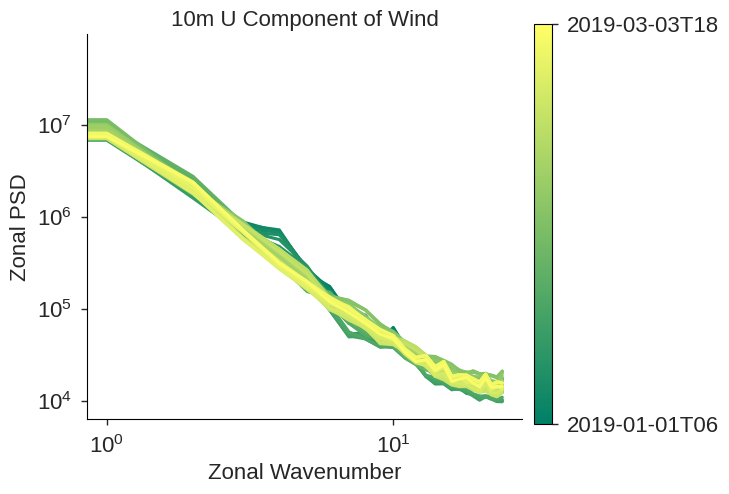

In [9]:
fig, ax = plt.subplots(figsize=(6,5))

cmap = "summer"
timesel = sds.time.values[:500:12]
n_time = len(timesel)

for i, time in enumerate(timesel):
    plotme = sds["10m_u_component_of_wind"]
    plotme = plotme.sortby("latitude").sel(latitude=slice(80, 85))
    plotme = plotme.mean("latitude")
    plotme = plotme.isel(time=i)
    plotme.plot(
        ax=ax,
        yscale="log",
        xscale="log",
        color=plt.get_cmap(cmap)(int(i/n_time * 256)),
    )
fig.subplots_adjust(right=.85)
cax = fig.add_axes([.87, .1, .03, .8])
cbar = ColorbarBase(cax, cmap=plt.get_cmap(cmap), orientation="vertical", ticks=[0, 1])
cbar.ax.set_yticklabels([str(t)[:13] for t in [timesel[0], timesel[-1]]])

ax.set(
    ylabel="Zonal PSD",
    xlabel="Zonal Wavenumber",
    title="10m U Component of Wind",
)
#fig.savefig("figures/long_forecast_spectrum_2019_ugrd10m.jpeg", bbox_inches="tight", dpi=300)

In [10]:
mapper = SpatialMap()

In [11]:
ds["10m_wind_speed"] = np.sqrt(ds["ugrd10m"]**2 + ds["vgrd10m"]**2)
era["10m_wind_speed"] = np.sqrt(era["10m_u_component_of_wind"]**2 + era["10m_v_component_of_wind"]**2)

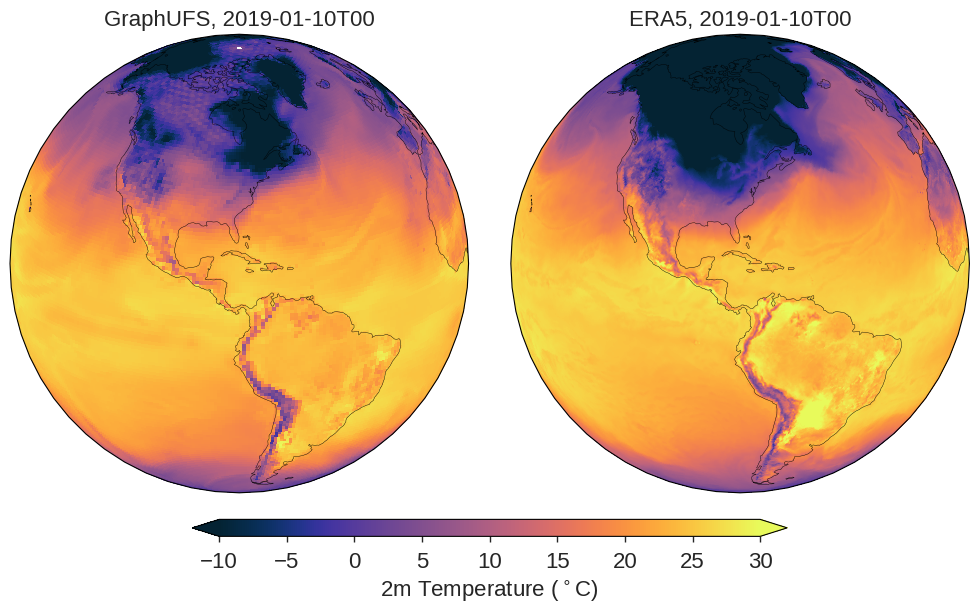

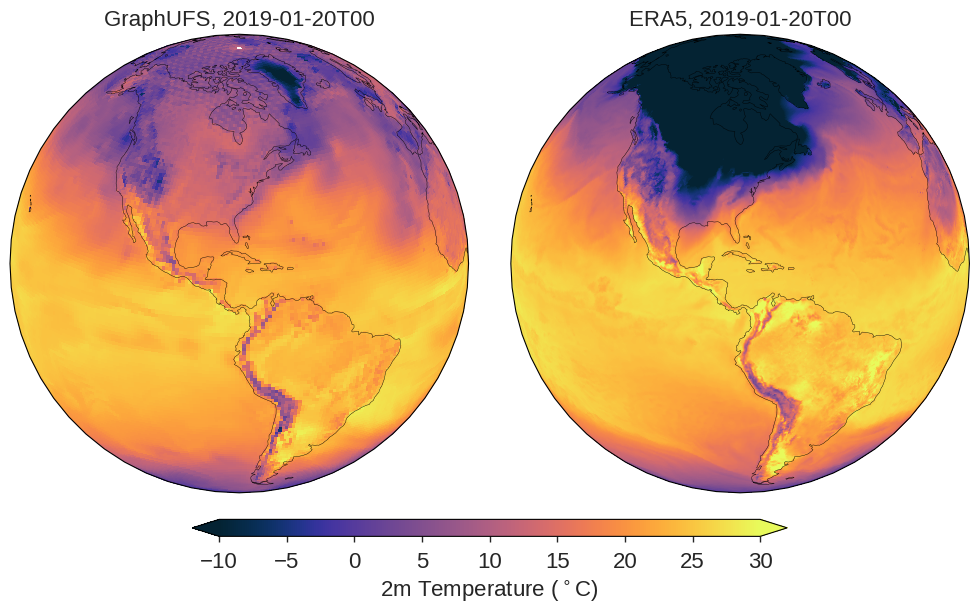

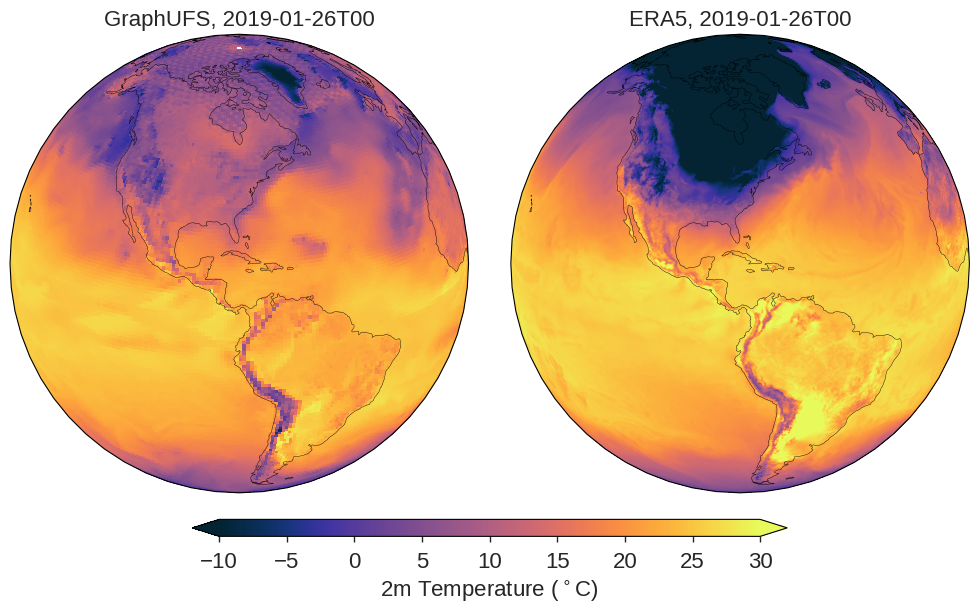

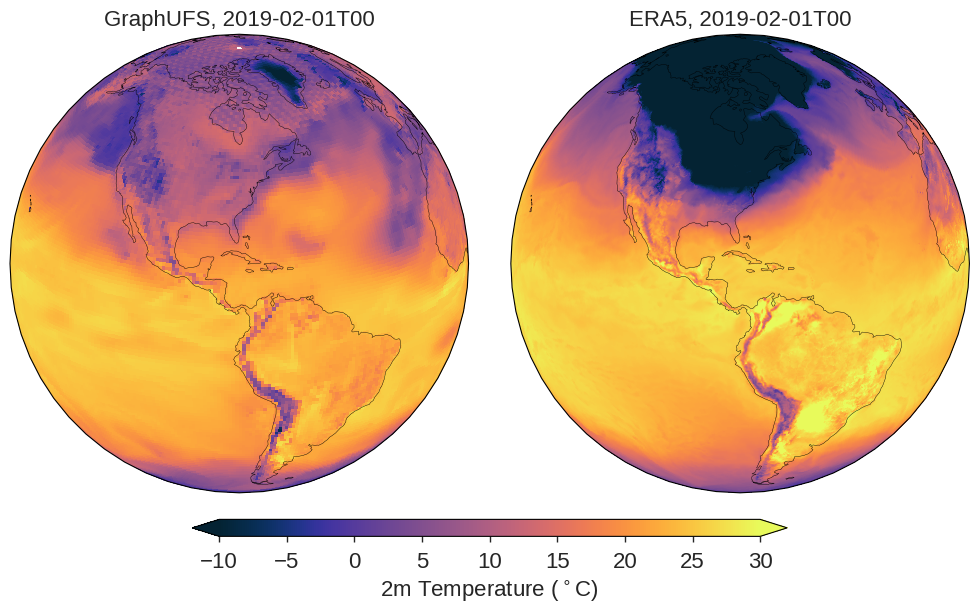

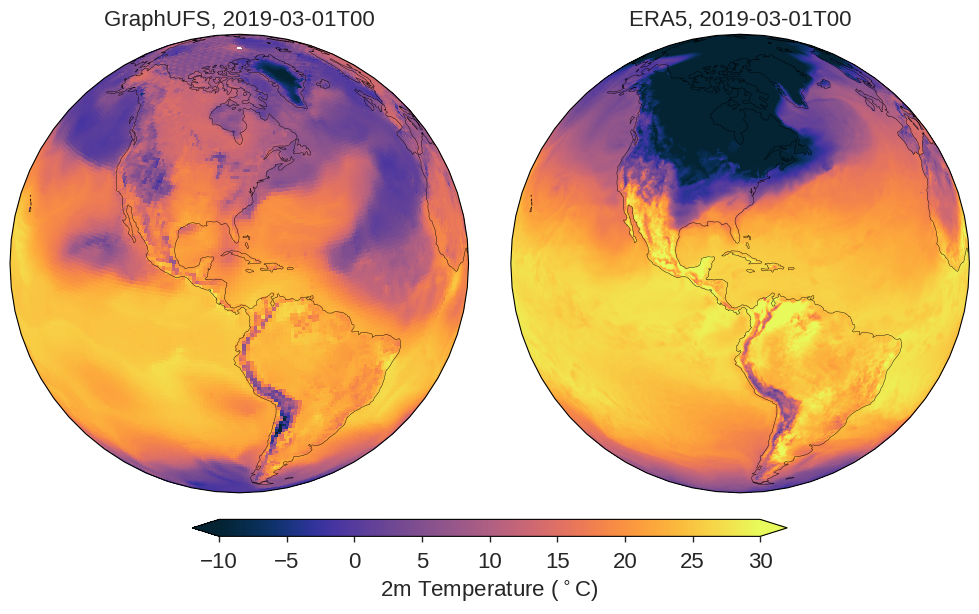

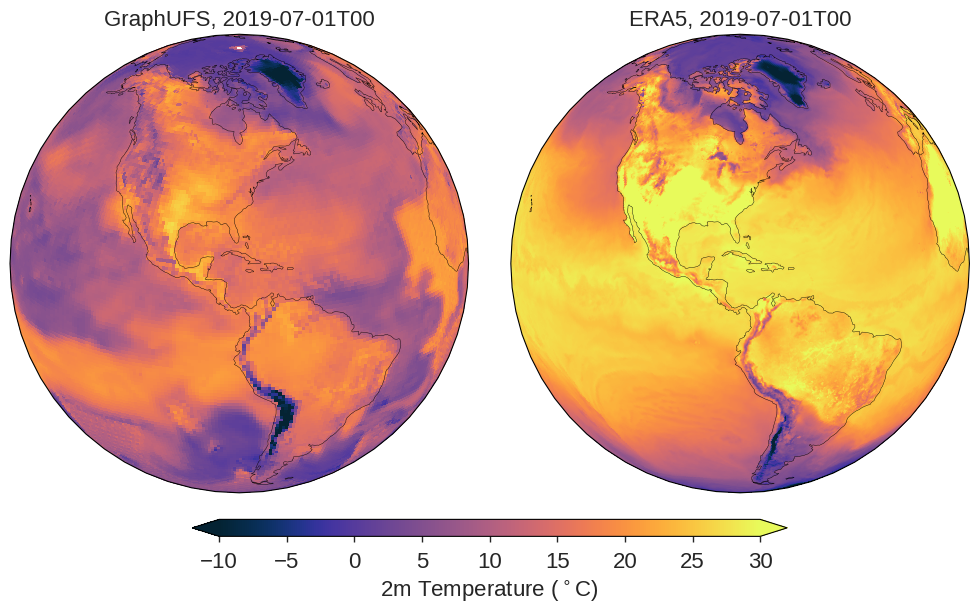

In [12]:
dates = [
    "2019-01-10T00",
    "2019-01-20T00",
    "2019-01-26T00",
    "2019-02-01T00",
    "2019-03-01T00",
    "2019-07-01T00",
]

#dates = ["2019-01-08T00"]

for date in dates:
    fig, axs = mapper.plot(
        ds["tmp2m"].sel(time=date),
        era["2m_temperature"].sel(time=[date]),
    );
    #fig.savefig(f"figures/long_forecast_tmp2m_{date}.jpeg", bbox_inches="tight", dpi=300)

In [179]:
import xmovie

In [195]:
def custom_func(xds, fig, idate, *args, **kwargs):

    gda = xds["tmp2m"].isel(time=idate)
    erada = xds["2m_temperature"].sel(time=[gda.time.values])

    gda = gda-273.15
    erada = erada-273.15

    axs = [fig.add_subplot(1, 2, i) for i in [1, 2]]
    gda.plot(ax=axs[0], **kwargs)
    erada.plot(ax=axs[1], **kwargs)
    for ax in axs:
        ax.set(
            ylabel="",
            xlabel="",
        )
    axs[0].set(title=f"GraphUFS, fhr = {(idate+1)*6}h")
    axs[1].set(title=f"ERA5, {str(erada.time.values[0])[:13]}")
    
    return None, None

In [200]:
gda = ds["tmp2m"].isel(time=slice(100)).load()
eda = era["2m_temperature"].sel(time=gda.time.values).load();

In [201]:
mymovie = xmovie.Movie(
    xr.Dataset({
        "tmp2m": gda,
        "2m_temperature": eda,
    }),
    custom_func,
    input_check=False,
    cmap="cmo.thermal",
    vmin=-10,
    vmax=30,
)

In [202]:
mymovie.save("figures/long_forecast_tmp2m.mp4", progress=True, overwrite_existing=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Movie created at long_forecast_tmp2m.mp4


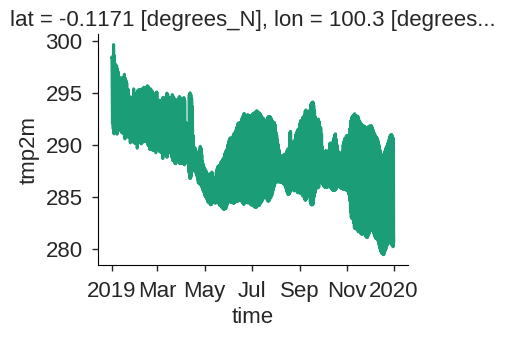

In [13]:
ds.tmp2m.squeeze().sel(lat=0, lon=100, method="nearest").plot()

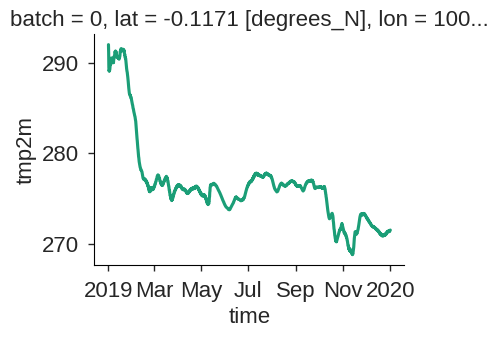

In [18]:
ds.tmp2m.squeeze().sel(lat=0, lon=100, method="nearest").plot()

In [ ]:
ds.tmp2m